## Environment Setup

In [12]:
import sys
import os
import pathlib

# Configure paths
NOTEBOOK_DIR = pathlib.Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'Notebooks' else NOTEBOOK_DIR
SCRIPTS_DIR = PROJECT_ROOT / 'scripts'

if str(SCRIPTS_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPTS_DIR))

# Verify GPU
import torch
print(f"Python: {sys.version.split()[0]}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Python: 3.10.19
PyTorch: 2.7.0+cu126
CUDA Available: True
GPU: NVIDIA GeForce RTX 2060
VRAM: 6.0 GB


In [13]:
# Import dependencies
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from io import BytesIO
import ast
import json

from utils import get_model
from conversation_memory import MultiTurnInference, ConversationMemory

# Helper function to display images
def display_image(img_source, title="Image", figsize=(12, 8)):
    """Display image from path or URL."""
    if isinstance(img_source, str):
        if img_source.startswith('http'):
            response = requests.get(img_source)
            img = Image.open(BytesIO(response.content))
        else:
            img = Image.open(img_source)
    else:
        img = img_source
    
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    return img

# Helper to visualize bounding boxes
def visualize_bbox(img, bbox_str, label="Object", color='red'):
    """Visualize bounding box on image."""
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    try:
        bbox = ast.literal_eval(bbox_str)
        if bbox and len(bbox) == 4:
            x1, y1, x2, y2 = bbox
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=3, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-10, label, color='white', fontsize=12,
                   bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
    except Exception as e:
        print(f"Could not parse bbox: {e}")
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Helper to visualize points
def visualize_points(img, points_str, labels=None, color='red'):
    """Visualize points on image."""
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    try:
        points = ast.literal_eval(points_str)
        if points:
            for i, (x, y) in enumerate(points):
                ax.scatter(x, y, c=color, s=200, marker='x', linewidths=3, zorder=5)
                label = labels[i] if labels and i < len(labels) else f"Point {i+1}"
                ax.annotate(label, (x, y), xytext=(x+15, y-15),
                           fontsize=11, color='white',
                           bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
    except Exception as e:
        print(f"Could not parse points: {e}")
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()

print("Helpers loaded successfully.")

Helpers loaded successfully.


## Load Model

In [14]:
print("Loading RoboBrain 2.0 model...")
model, repo_dir = get_model()
print(f"Model loaded from: {repo_dir}")

# Initialize chat
chat = MultiTurnInference(model, repo_dir)
print(f"\nMulti-turn inference ready.")
print(f"  - Context mode: {'Enabled' if chat.use_context else 'Disabled'}")
print(f"  - Max history: {chat.memory.max_turns} turns")

Loading RoboBrain 2.0 model...
Using local weights from: /home/yasiru/Documents/github/Robobrain-2.0/weights
Using device: cuda — model path: /home/yasiru/Documents/github/Robobrain-2.0/weights
Loading Checkpoint ...
Loading Checkpoint ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model thinking support: True
✅ Model loaded.
Model loaded from: /home/yasiru/Documents/github/Robobrain-2.0/RoboBrain2.0_lib

Multi-turn inference ready.
  - Context mode: Enabled
  - Max history: 20 turns


---

## Scenario 1: Robotic Manipulation Pipeline

This scenario simulates a complete robotic manipulation workflow:
1. Scene understanding
2. Object identification
3. Target localization (grounding)
4. Grasp point detection (affordance)
5. Motion planning (trajectory)

🔄 Conversation memory cleared.
📷 Image set: /home/yasiru/Documents/github/Robobrain-2.0/RoboBrain2.0_lib/assets/demo/affordance.jpg


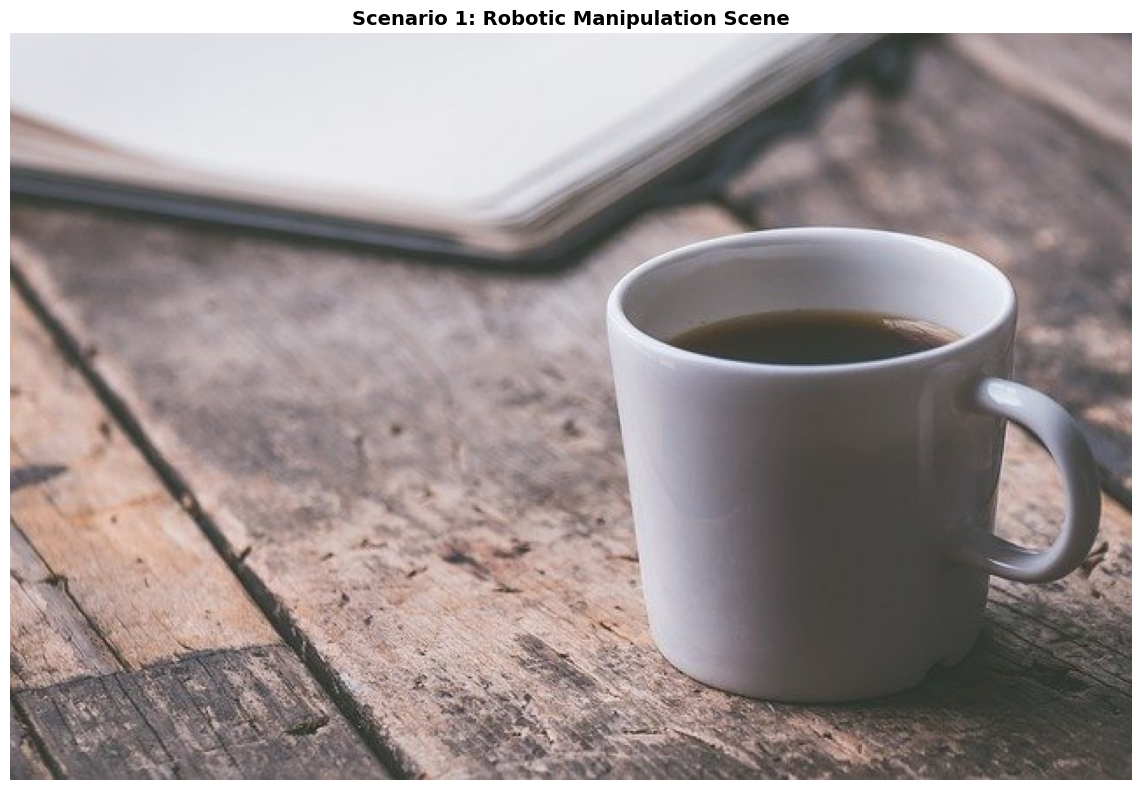

In [15]:
# Reset for new scenario
chat.reset()

# Use affordance demo image (typically shows graspable objects)
affordance_img_path = repo_dir / "assets/demo/affordance.jpg"
if affordance_img_path.exists():
    chat.set_image(str(affordance_img_path))
    affordance_img = display_image(str(affordance_img_path), "Scenario 1: Robotic Manipulation Scene")
else:
    # Fallback to a kitchen scene URL
    fallback_url = "http://images.cocodataset.org/val2017/000000397133.jpg"
    chat.set_image(fallback_url)
    affordance_img = display_image(fallback_url, "Scenario 1: Robotic Manipulation Scene")

### Step 1: Scene Understanding

In [16]:
# Step 1: Understand the scene
r1 = chat.ask(
    "Describe this scene. What objects are present and where are they located?",
    task="general",
    enable_thinking=False
)

print("[STEP 1] Scene Understanding")
print(f"Query: Describe this scene. What objects are present?")
print(f"Response: {r1['answer']}")
print(f"Turn: {r1['turn_number']}")


==================== INPUT ====================
Describe this scene. What objects are present and where are they located?

Thinking disabled (but supported).
Running inference ...
[STEP 1] Scene Understanding
Query: Describe this scene. What objects are present?


KeyError: 'answer'

### Step 2: Object Identification for Task

In [ ]:
# Step 2: Ask which object to manipulate based on context
r2 = chat.ask(
    "If a robot needs to pick up something to help a human, which object from the ones you described would be most useful to grasp first?",
    task="general",
    enable_thinking=False
)

print("[STEP 2] Object Selection")
print(f"Query: Which object should the robot grasp first?")
print(f"Response: {r2['answer']}")
print(f"Turn: {r2['turn_number']} (context from previous turn used)")

### Step 3: Target Localization (Grounding)

In [ ]:
# Step 3: Ground the selected object
r3 = chat.ground("the object you recommended to grasp")

print("[STEP 3] Target Localization (Grounding)")
print(f"Query: Locate the recommended object")
print(f"Bounding Box: {r3['answer']}")
print(f"Turn: {r3['turn_number']}")

# Visualize
visualize_bbox(affordance_img, r3['answer'], "Target Object", 'blue')

### Step 4: Grasp Point Detection (Affordance)

In [ ]:
# Step 4: Get affordance for grasping
r4 = chat.get_affordance("grasp the object we located")

print("[STEP 4] Grasp Affordance")
print(f"Query: Where should the robot grasp?")
print(f"Affordance: {r4['answer']}")
print(f"Turn: {r4['turn_number']}")

### Step 5: Motion Planning (Trajectory)

In [ ]:
# Step 5: Plan trajectory to pick up the object
r5 = chat.get_trajectory("pick up the object from its current position")

print("[STEP 5] Motion Trajectory")
print(f"Query: Plan trajectory to pick up the object")
print(f"Trajectory: {r5['answer']}")
print(f"Turn: {r5['turn_number']}")

### Pipeline Summary

In [ ]:
# Display full conversation history for this pipeline
print("=" * 60)
print("ROBOTIC MANIPULATION PIPELINE - CONVERSATION LOG")
print("=" * 60)
chat.show_history()

print("\n" + "=" * 60)
print("PIPELINE SUMMARY")
print("=" * 60)
print(f"Total turns: {len(chat.memory)}")
print(f"Tasks used: general -> general -> grounding -> affordance -> trajectory")
print(f"Context maintained across all steps: Yes")

---

## Scenario 2: Multi-Object Comparative Analysis

This scenario demonstrates:
1. Identifying multiple objects
2. Comparing their properties
3. Locating each one in sequence
4. Making decisions based on accumulated context

In [ ]:
# Reset for new scenario
chat.reset()

# Use pointing demo image (typically has multiple similar objects)
pointing_img_path = repo_dir / "assets/demo/pointing.jpg"
if pointing_img_path.exists():
    chat.set_image(str(pointing_img_path))
    pointing_img = display_image(str(pointing_img_path), "Scenario 2: Multi-Object Scene")
else:
    # Fallback
    fallback_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    chat.set_image(fallback_url)
    pointing_img = display_image(fallback_url, "Scenario 2: Multi-Object Scene")

In [ ]:
# Turn 1: Count objects
r1 = chat.ask(
    "How many distinct objects or items can you identify in this image? List them.",
    enable_thinking=False
)

print("[Turn 1] Object Enumeration")
print(f"Response: {r1['answer']}")

In [ ]:
# Turn 2: Compare objects
r2 = chat.ask(
    "Among the objects you listed, which ones are similar to each other? What makes them similar?",
    enable_thinking=False
)

print("[Turn 2] Object Comparison")
print(f"Response: {r2['answer']}")

In [ ]:
# Turn 3: Identify differences
r3 = chat.ask(
    "Now tell me what differences exist between those similar objects. Focus on position, size, or appearance.",
    enable_thinking=False
)

print("[Turn 3] Difference Analysis")
print(f"Response: {r3['answer']}")

In [ ]:
# Turn 4: Point to all similar objects
r4 = chat.point_at("all the similar objects you mentioned")

print("[Turn 4] Pointing to Similar Objects")
print(f"Points: {r4['answer']}")

# Visualize
visualize_points(pointing_img, r4['answer'], color='green')

In [ ]:
# Turn 5: Decision based on context
r5 = chat.ask(
    "Based on the differences you identified, which object would be easiest for a robot to pick up and why?",
    enable_thinking=False
)

print("[Turn 5] Decision Making")
print(f"Response: {r5['answer']}")

In [ ]:
# Turn 6: Ground the selected object
r6 = chat.ground("the easiest object to pick up that you just recommended")

print("[Turn 6] Grounding Selected Object")
print(f"Bounding Box: {r6['answer']}")

visualize_bbox(pointing_img, r6['answer'], "Selected Object", 'orange')

---

## Scenario 3: Cross-Image Context Transfer

This scenario demonstrates how to:
1. Analyze one image
2. Save the conversation
3. Switch to a different image
4. Reference information from the previous image

In [ ]:
# Reset for new scenario
chat.reset()

# Image 1: Navigation scene
nav_img_path = repo_dir / "assets/demo/navigation.jpg"
if nav_img_path.exists():
    chat.set_image(str(nav_img_path))
    nav_img = display_image(str(nav_img_path), "Image 1: Navigation Scene")
else:
    fallback_url = "http://images.cocodataset.org/val2017/000000397133.jpg"
    chat.set_image(fallback_url)
    nav_img = display_image(fallback_url, "Image 1: Navigation Scene")

In [ ]:
# Analyze first image
r1 = chat.ask(
    "Describe this environment. What type of space is this and what are the key landmarks?",
    enable_thinking=False
)

print("[Image 1, Turn 1] Environment Analysis")
print(f"Response: {r1['answer']}")

In [ ]:
# Get navigation-relevant info
r2 = chat.ask(
    "If a robot needed to navigate through this space, what obstacles should it avoid?",
    enable_thinking=False
)

print("[Image 1, Turn 2] Obstacle Identification")
print(f"Response: {r2['answer']}")

In [ ]:
# Save conversation state
save_path_1 = str(PROJECT_ROOT / "conversations" / "image1_context.json")
chat.save_conversation(save_path_1)
print(f"Saved Image 1 conversation to: {save_path_1}")

# Store Image 1 summary for reference
image1_summary = chat.memory.get_conversation_summary()
print(f"\nImage 1 Summary: {image1_summary}")

In [ ]:
# Switch to Image 2 (keeping conversation history)
trajectory_img_path = repo_dir / "assets/demo/trajectory.jpg"
if trajectory_img_path.exists():
    chat.set_image(str(trajectory_img_path))
    trajectory_img = display_image(str(trajectory_img_path), "Image 2: Trajectory Planning Scene")
else:
    fallback_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    chat.set_image(fallback_url)
    trajectory_img = display_image(fallback_url, "Image 2: Trajectory Planning Scene")

In [ ]:
# Analyze new image with context from previous
r3 = chat.ask(
    "Now looking at this new image, describe what you see. Is this environment similar or different from the previous one?",
    enable_thinking=False
)

print("[Image 2, Turn 3] Cross-Image Comparison")
print(f"Response: {r3['answer']}")
print(f"\nNote: The model uses context from {r3['turn_number']} turns including previous image discussion.")

In [ ]:
# Plan trajectory on new image
r4 = chat.get_trajectory("move from left to right avoiding obstacles")

print("[Image 2, Turn 4] Trajectory Planning")
print(f"Trajectory: {r4['answer']}")

In [ ]:
# Save combined conversation
save_path_combined = str(PROJECT_ROOT / "conversations" / "cross_image_session.json")
chat.save_conversation(save_path_combined)

print("Full cross-image conversation saved.")
print(f"\nConversation spans {len(chat.memory)} turns across 2 images.")

---

## Scenario 4: Iterative Refinement

This scenario shows how to iteratively refine understanding through follow-up questions:
1. Get initial response
2. Ask for clarification
3. Request more specific details
4. Validate understanding

In [ ]:
# Reset and use grounding image
chat.reset()

grounding_img_path = repo_dir / "assets/demo/grounding.jpg"
if grounding_img_path.exists():
    chat.set_image(str(grounding_img_path))
    grounding_img = display_image(str(grounding_img_path), "Scenario 4: Iterative Refinement")
else:
    fallback_url = "http://images.cocodataset.org/val2017/000000397133.jpg"
    chat.set_image(fallback_url)
    grounding_img = display_image(fallback_url, "Scenario 4: Iterative Refinement")

In [ ]:
# Iteration 1: Initial broad question
r1 = chat.ask("What is happening in this image?", enable_thinking=False)

print("[Iteration 1] Initial Query")
print(f"Q: What is happening in this image?")
print(f"A: {r1['answer']}")

In [ ]:
# Iteration 2: Request clarification
r2 = chat.ask(
    "Can you be more specific about the main subject? What are they wearing and what position are they in?",
    enable_thinking=False
)

print("[Iteration 2] Clarification Request")
print(f"Q: Can you be more specific about the main subject?")
print(f"A: {r2['answer']}")

In [ ]:
# Iteration 3: Drill down further
r3 = chat.ask(
    "You mentioned specific details. Can you describe the spatial relationship between the subject and other objects in the scene?",
    enable_thinking=False
)

print("[Iteration 3] Spatial Analysis")
print(f"Q: Describe spatial relationships in the scene.")
print(f"A: {r3['answer']}")

In [ ]:
# Iteration 4: Validate with grounding
r4 = chat.ground("the main subject you have been describing")

print("[Iteration 4] Validation via Grounding")
print(f"Q: Locate the main subject we discussed.")
print(f"Bounding Box: {r4['answer']}")

visualize_bbox(grounding_img, r4['answer'], "Main Subject", 'purple')

In [ ]:
# Final validation question
r5 = chat.ask(
    "Based on everything we've discussed about this image, summarize the scene in one sentence.",
    enable_thinking=False
)

print("[Iteration 5] Final Summary")
print(f"Q: Summarize the scene in one sentence.")
print(f"A: {r5['answer']}")

---

## Scenario 5: Thinking Mode Deep Analysis

Demonstrate the thinking mode for complex reasoning tasks.

In [ ]:
# Reset for thinking demo
chat.reset()

# Use the cats image for complex reasoning
cats_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
chat.set_image(cats_url)
cats_img = display_image(cats_url, "Scenario 5: Thinking Mode Analysis")

In [ ]:
# Complex question with thinking enabled
r_think = chat.ask(
    "Analyze this scene as if you were a robot planning to interact with it. "
    "Consider: What objects are present? What are their relationships? "
    "What actions could be performed? What precautions should be taken?",
    task="general",
    enable_thinking=True
)

print("[THINKING MODE ANALYSIS]")
print("=" * 60)
print("\n[Thinking Process]")
thinking = r_think.get('thinking', 'Not available')
if thinking and thinking != 'Not available':
    # Display thinking in chunks for readability
    print(thinking[:1000])
    if len(thinking) > 1000:
        print(f"\n... [Thinking continues for {len(thinking)} total characters]")
else:
    print("Thinking output not captured.")

print("\n" + "=" * 60)
print("[Final Answer]")
print(r_think['answer'])

---

## Final Summary: All Scenarios

In [ ]:
print("=" * 70)
print("ADVANCED MULTI-TURN DEMO - SUMMARY")
print("=" * 70)

scenarios = [
    ("Robotic Manipulation Pipeline", "5 turns", "general -> grounding -> affordance -> trajectory"),
    ("Multi-Object Comparative Analysis", "6 turns", "general -> pointing -> grounding"),
    ("Cross-Image Context Transfer", "4 turns", "Maintained context across 2 images"),
    ("Iterative Refinement", "5 turns", "Progressive detail extraction"),
    ("Thinking Mode Analysis", "1 turn", "Chain-of-thought reasoning"),
]

print(f"\n{'Scenario':<35} {'Turns':<12} {'Key Feature'}")
print("-" * 70)
for name, turns, feature in scenarios:
    print(f"{name:<35} {turns:<12} {feature}")

print("\n" + "=" * 70)
print("Key Takeaways:")
print("  1. Multi-turn memory enables complex, contextual workflows")
print("  2. Task types can be mixed within a single conversation")
print("  3. Context persists across image changes when needed")
print("  4. Conversations can be saved and resumed")
print("  5. Thinking mode provides insight into model reasoning")
print("=" * 70)

---

## Cleanup

In [ ]:
# Clear GPU memory
import gc

chat.reset()
gc.collect()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU memory cleared.")
    print(f"Current allocation: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

print("\nNotebook complete.")